###**TIKI SUPPLY CHAIN - DATA ANALYSIS TEST**

>**1. BUSINESS PROBLEM**

**Domain:** Standard process for an order at Tiki as below: 

purchase --> verify --> pick --> pack --> dispatch --> deliver

Data is given from May 2017 to Jun 2017 in 1 file: da_test_data

-> Data may contain some minor discrepancy, try to figure out and make a summary laying out important insights about operations health

* What should be our priority?
* How is the performance of delivery lead-time? 2 hours, 1 days, 2 days and so on?
* Evaluate the failed delivery rate and the reason behind it
* Evaluate the cancellation rate.

>**2. EXPLORATORY DATA ANALYSIS**

>>*2.1  Overview Data* 

In [288]:
# Import libraries
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.gridspec import GridSpec
import seaborn as sns
# Option to specify the default size of plots by seaborn
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [ ]:
# Install PyDrive, modules. Authenticate and create the PyDrive client
!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [290]:
# Get the file
downloaded = drive.CreateFile({'id':"19q9eOzbBV32YSobaLn5GBDgmoyptZnG8"})  
downloaded.GetContentFile('da_test_data.csv') 

In [291]:
# Read the dataset into notebook
df=pd.read_csv('da_test_data.csv',encoding='latin-1')
# View top 5 records
df.head()

,increment_id,order_value,total_units_order,order_type,status,ship_to,warehouse,is_2h,purchase_at,actual_fulfilled,actual_pickup,actual_package,actual_outstock,actual_delivery,deliveried_by,cancelled_at,fail_delivery,delivery_deadline,reason_cancel/fail_delivery
0,1,53000,1.0,instock,canceled,H<U+1ED3> Chí Minh,2,0,2017-06-27 17:22,2017-06-27 17:22,NaN,NaN,NaN,NaN,NaN,2017-06-27 10:25,0,NaN,NaN
1,2,84000,2.0,instock,canceled,H<U+1ED3> Chí Minh,1,0,2017-06-23 12:23,NaN,NaN,NaN,NaN,NaN,NaN,2017-06-23 05:30,0,NaN,them/bot san pham
2,3,187000,3.0,backorder,canceled,H<U+1ED3> Chí Minh,1,0,2017-06-09 10:10,2017-06-14 11:34,NaN,NaN,NaN,NaN,NaN,2017-06-14 09:01,0,NaN,giao nhieu lan khong thanh cong
3,4,292000,1.0,instock,canceled,H<U+1ED3> Chí Minh,1,0,2017-06-26 17:39,2017-06-26 17:39,NaN,NaN,NaN,NaN,NaN,2017-06-27 09:13,0,NaN,giao nhieu lan khong thanh cong
4,5,0,1.0,instock,canceled,Hà N<U+1ED9>i,2,0,2017-06-10 17:50,NaN,NaN,NaN,NaN,NaN,NaN,2017-06-19 06:14,0,NaN,NaN


In [292]:
# Information about da_test_data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629064 entries, 0 to 629063
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   increment_id                 629064 non-null  int64  
 1   order_value                  629064 non-null  int64  
 2   total_units_order            629049 non-null  float64
 3   order_type                   629062 non-null  object 
 4   status                       629064 non-null  object 
 5   ship_to                      629064 non-null  object 
 6   warehouse                    629064 non-null  int64  
 7   is_2h                        629064 non-null  int64  
 8   purchase_at                  629064 non-null  object 
 9   actual_fulfilled             569026 non-null  object 
 10  actual_pickup                526654 non-null  object 
 11  actual_package               525202 non-null  object 
 12  actual_outstock              345605 non-null  object 
 13 

>>*2.2  Cleaning Data* 

>>>*2.2.1 Handling the missing or null values*

In [293]:
# Get the number of missing data points per column
pd.isnull(df).sum(axis=0)

increment_id                        0
order_value                         0
total_units_order                  15
order_type                          2
status                              0
ship_to                             0
warehouse                           0
is_2h                               0
purchase_at                         0
actual_fulfilled                60038
actual_pickup                  102410
actual_package                 103862
actual_outstock                283459
actual_delivery                129281
deliveried_by                  105610
cancelled_at                   516694
fail_delivery                       0
delivery_deadline                2873
reason_cancel/fail_delivery    518089
dtype: int64

This seems like a lot! I noticed that, having 3 columns include: "warehouse", "actual_pickup", "actual_package" don't contain much helpful insight for my analysis, should be removed but need to fill in missing values of "actual_outstock" by "actual_package" values first.

There are 5 columns: actual_fulfilled, actual_outstock,  actual_delivery, cancelled_at, reason_cancel/fail_delivery which most of their values are missing because they don't exist, these values I probably want to keep as NaN. 

Number missing values of 2 columns : total_units_order, order_type is negligible so the simplest way is to remove them. 

Finally, the missing value of 2 columns : deliveried_by and delivery_deadline due not to be recored => try to figure out and fill in

In [294]:
# Fill in missing values of actual_outstock by "actual_package" values
df.actual_outstock.fillna(df.actual_package,inplace=True)

In [295]:
# Drop 3 columns: warehouse, actual_pickup, actual_package, 
df.drop(columns=['warehouse','actual_pickup','actual_package'],inplace=True)

In [296]:
# Remove missing values for total_units_order and order_type
df = df[df['total_units_order'].notna()]
df = df[df['order_type'].notna()]

In [297]:
# Assign a new category, say "U" stand for unknown class to replace for missing values
df['deliveried_by']=df['deliveried_by'].fillna('U')
# Sort dataframe by "purchase_at" column from oldest to latest
df=df.sort_values('purchase_at')
# Replace missing values for "delivery_deadline" column by using forward & backward fill method
df['delivery_deadline']=df['delivery_deadline'].fillna(method='bfill').fillna(method='ffill')
pd.isnull(df).sum(axis=0)

increment_id                        0
order_value                         0
total_units_order                   0
order_type                          0
status                              0
ship_to                             0
is_2h                               0
purchase_at                         0
actual_fulfilled                60021
actual_outstock                103837
actual_delivery                129264
deliveried_by                       0
cancelled_at                   516680
fail_delivery                       0
delivery_deadline                   0
reason_cancel/fail_delivery    518074
dtype: int64

>>>*2.2.2 Dropping the duplicated rows*

In [298]:
# Get the number of duplicated rows
duplicate_row_df=df[df.duplicated()]
print('Number of duplicated rows: ', duplicate_row_df.shape)

Number of duplicated rows:  (0, 16)


=> This dataset has no duplication

>>>*2.2.3 Dropping outliers*

In [299]:
# Summary statistics for da_test_data
df.describe().round(2)

,increment_id,order_value,total_units_order,is_2h,fail_delivery
count,629047.00,6.290470e+05,629047.00,629047.0,629047.00
mean,314527.49,4.842854e+05,2.91,0.1,0.03
std,181594.74,8.861972e+06,5.32,0.3,0.18
min,1.00,-9.000000e+03,1.00,0.0,0.00
25%,157262.50,7.000000e+04,1.00,0.0,0.00
50%,314524.00,1.300000e+05,2.00,0.0,0.00
75%,471791.50,2.440000e+05,4.00,0.0,0.00
max,629064.00,3.832500e+09,1500.00,1.0,1.00


In [300]:
# Remove order_value with negative values
df=df[df.order_value >= 0]
df.describe().round(2)

,increment_id,order_value,total_units_order,is_2h,fail_delivery
count,629042.00,6.290420e+05,629042.00,629042.0,629042.00
mean,314527.74,4.842893e+05,2.91,0.1,0.03
std,181595.00,8.862007e+06,5.32,0.3,0.18
min,1.00,0.000000e+00,1.00,0.0,0.00
25%,157262.25,7.000000e+04,1.00,0.0,0.00
50%,314522.50,1.300000e+05,2.00,0.0,0.00
75%,471792.75,2.440000e+05,4.00,0.0,0.00
max,629064.00,3.832500e+09,1500.00,1.0,1.00


>>*2.3  Processing Data* 

In [301]:
# Format datetime value
df['purchase_at']=pd.to_datetime(df['purchase_at'])
df['actual_fulfilled']=pd.to_datetime(df['actual_fulfilled'])
df['actual_delivery']=pd.to_datetime(df['actual_delivery'])
df['actual_outstock']=pd.to_datetime(df['actual_outstock'])
df['cancelled_at']=pd.to_datetime(df['cancelled_at'])
df['delivery_deadline']=pd.to_datetime(df['delivery_deadline'])

In [302]:
# Add the columns: order_date, dayofweek and hourofday from the "purchase_at"
df.insert(loc=8, column='order_date', value=df['purchase_at'].map(lambda x: 10000*x.year + 100*x.month + x.day))
# +1 to make Monday=1.....until Sunday=7
df.insert(loc=9, column='dayofweek', value=(df.purchase_at.dt.dayofweek)+1)
df.insert(loc=10, column='hourofday', value=df.purchase_at.dt.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df.insert(loc=11, column='time_day', value=pd.cut(df['hourofday'], hours_bins, labels=hours_labels))
df=df.astype({'time_day':str})

In [303]:
# Change the column names
df.rename(columns={'increment_id':'order_id','ship_to':'customer_area'},inplace=True)
df.head()

,order_id,order_value,total_units_order,order_type,status,customer_area,is_2h,purchase_at,order_date,dayofweek,hourofday,time_day,actual_fulfilled,actual_outstock,actual_delivery,deliveried_by,cancelled_at,fail_delivery,delivery_deadline,reason_cancel/fail_delivery
44978,44979,138000,2.0,backorder,canceled,H<U+1ED3> Chí Minh,0,2017-05-28,20170528,7,0,Dawn,NaT,NaT,NaT,U,2017-05-27 19:40:00,0,2017-06-02,khac
26532,26533,51000,1.0,instock,complete,H<U+1ED3> Chí Minh,0,2017-05-28,20170528,7,0,Dawn,2017-05-28 00:00:00,2017-05-30 07:56:00,2017-05-30 12:33:00,A4,NaT,0,2017-05-31,NaN
10229,10230,263000,1.0,instock,complete,H<U+1ED3> Chí Minh,0,2017-05-28,20170528,7,0,Dawn,2017-05-28 00:01:00,2017-05-30 08:36:00,2017-05-30 10:51:00,A4,NaT,0,2017-05-30,NaN
19921,19922,117000,4.0,instock,complete,H<U+1ED3> Chí Minh,0,2017-05-28,20170528,7,0,Dawn,2017-05-28 00:00:00,2017-05-28 10:02:00,2017-05-29 14:17:00,A1,NaT,0,2017-05-31,NaN
14517,14518,8837000,4.0,instock,canceled,Khánh Hòa,0,2017-05-28,20170528,7,0,Dawn,2017-05-28 00:00:00,NaT,NaT,U,2017-05-27 17:02:00,0,2017-05-31,khong con nhu cau


>>*2.4  Data Analysis*

>>>*2.4.1  What should be our priority?* 

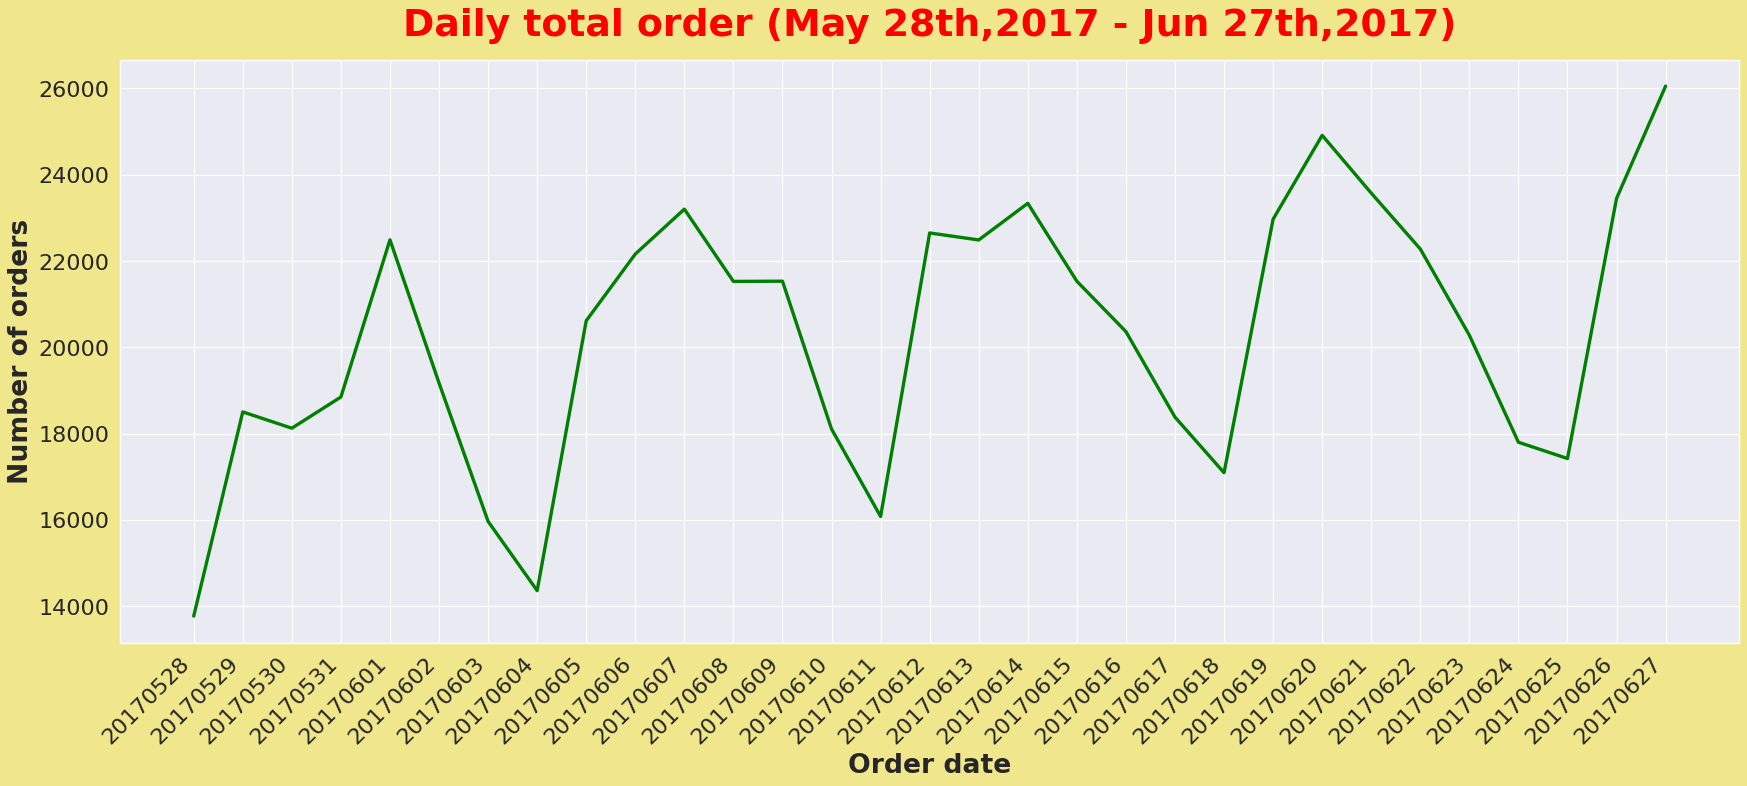

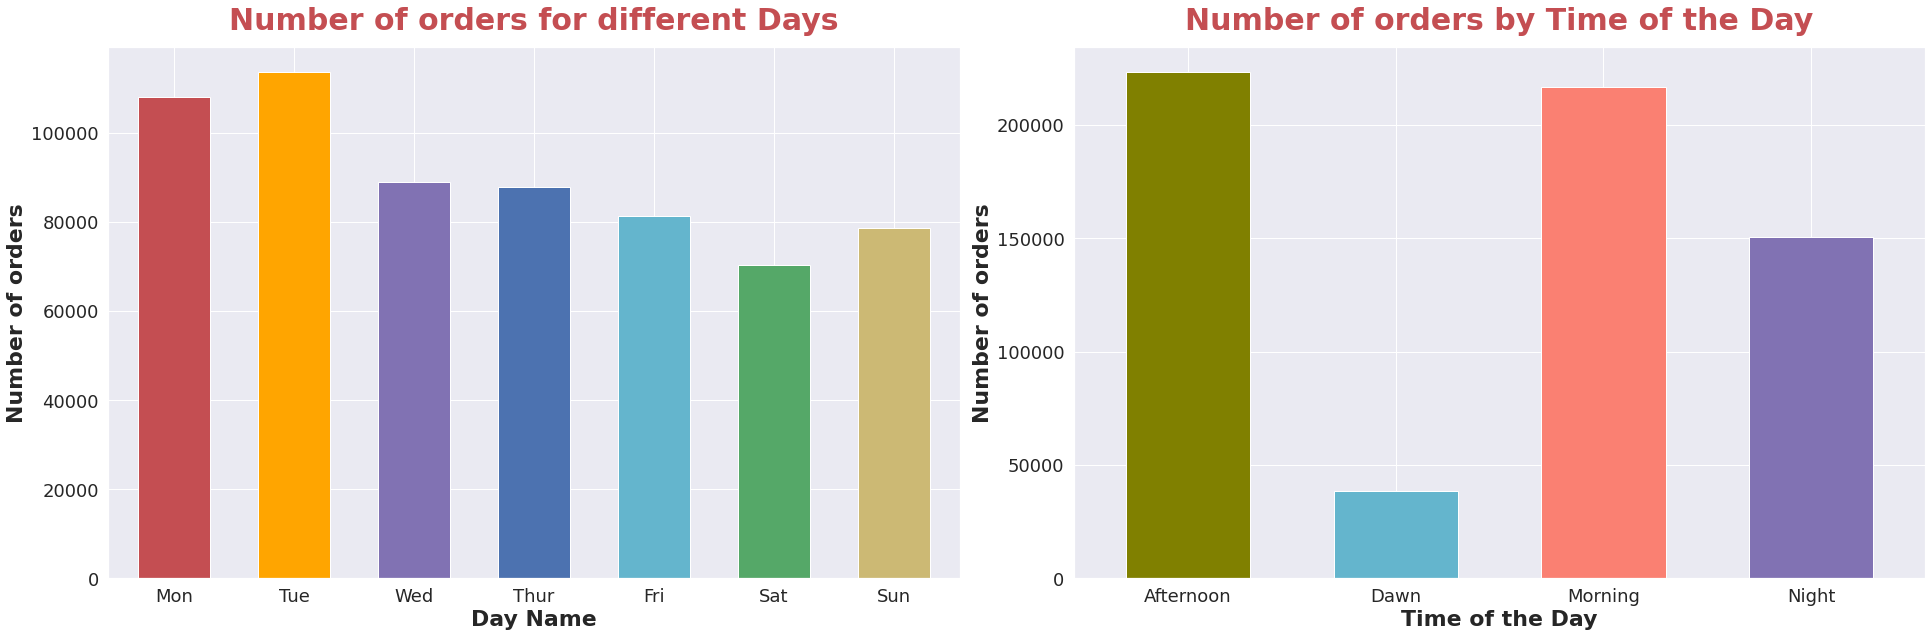

In [305]:
# Plot number of orders for daily 
Order_by_date=df.groupby('order_date')['order_id'].count().reset_index()
Order_by_date=Order_by_date.astype({'order_date':str})
plt.figure(num=None, figsize=(22, 10),dpi=80, facecolor='khaki',edgecolor='k')
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light',fontsize='medium')
sns.lineplot(data=Order_by_date, x="order_date", y="order_id", color='green', linewidth=3)
plt.title('Daily total order (May 28th,2017 - Jun 27th,2017)',color='red',fontsize=34,fontweight='bold',y=1.03)
plt.xlabel('Order date',fontsize=24, fontweight='bold')
plt.ylabel('Number of orders',fontsize=24,fontweight='bold')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
# Plot number of orders per dayofweek and per hourofday
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(27,9))
## Graph per day
plt.subplot(1,2,1)
ax = df.groupby('order_id')['dayofweek'].unique().value_counts().sort_index().plot(kind='bar',\
                  color=['r','orange','m','b','c','g','y'],width=0.6)
ax.set_xlabel('Day Name',fontsize=22,fontweight='bold' )
ax.set_ylabel('Number of orders',fontsize=22,fontweight='bold')
ax.set_title('Number of orders for different Days',fontsize=30,fontweight='bold', color='r',y=1.02)
ax.set_xticklabels(('Mon','Tue','Wed','Thur','Fri','Sat','Sun'), rotation='horizontal', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
## Graph per hour
plt.subplot(1,2,2)
ax1 = df.groupby('order_id')['time_day'].unique().value_counts().sort_index().plot(kind='bar',\
                  color=['olive','c','salmon','m'], width=0.6)
ax1.set_xlabel('Time of the Day',fontsize=22,fontweight='bold' )
ax1.set_ylabel('Number of orders',fontsize=22,fontweight='bold')
ax1.set_title('Number of orders by Time of the Day',fontsize=30,fontweight='bold', color='r',y=1.02)
ax1.set_xticklabels(('Afternoon','Dawn', 'Morning', 'Night'),rotation='horizontal', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()

By the chart above we can conclude:

E-commerce at Tiki has a slightly growing trend along the time. We can see order numbers fluctuate periodically:  increase at the beginning of the week and decrease sharply at the end of the week,  but in general we can see clear that customers are more prone to buy things online than before.

Monday & Tuesday are the prefered days for Tiki's customers and they tend to buy more at afternoons & mornings.

In [306]:
# Determine % (Number of orders & Order value) by customer area
Order_by_area=df.groupby('customer_area').agg({'order_id':'count','order_value':'sum'}).\
sort_values('order_value', ascending=True).reset_index()
Order_by_area.rename(columns={'order_id':'No_order'},inplace=True)
Order_by_area['% No orders in total']=round(Order_by_area['No_order']/Order_by_area['No_order'].sum()*100,0)
Order_by_area['% Order value in total']=round(Order_by_area['order_value']/Order_by_area['order_value'].sum()*100,0)
Order_by_area.describe()

,No_order,order_value,% No orders in total,% Order value in total
count,63.000000,6.300000e+01,63.000000,63.000000
mean,9984.793651,4.835529e+09,1.523810,1.444444
std,36489.326553,2.242920e+10,5.780549,7.352370
min,400.000000,9.003000e+07,0.000000,0.000000
25%,1930.000000,5.129505e+08,0.000000,0.000000
50%,3164.000000,9.312640e+08,1.000000,0.000000
75%,5351.000000,1.560613e+09,1.000000,0.500000
max,273499.000000,1.712991e+11,43.000000,56.000000


Top 10 customer area by Order value and Number of orders


,customer_area,% No orders in total,% Order value in total
0,H<U+1ED3> Chí Minh,43.0,56.0
1,Hà N<U+1ED9>i,18.0,18.0
2,Ðà N<U+1EB5>ng,2.0,2.0
3,Bình Duong,2.0,2.0
4,Ð<U+1ED3>ng Nai,3.0,2.0
5,Lâm Ð<U+1ED3>ng,1.0,1.0
6,C<U+1EA7>n Tho,1.0,1.0
7,Khánh Hòa,1.0,1.0
8,Bà R<U+1ECB>a - Vung Tàu,1.0,1.0
9,H<U+1EA3>i Phòng,1.0,1.0


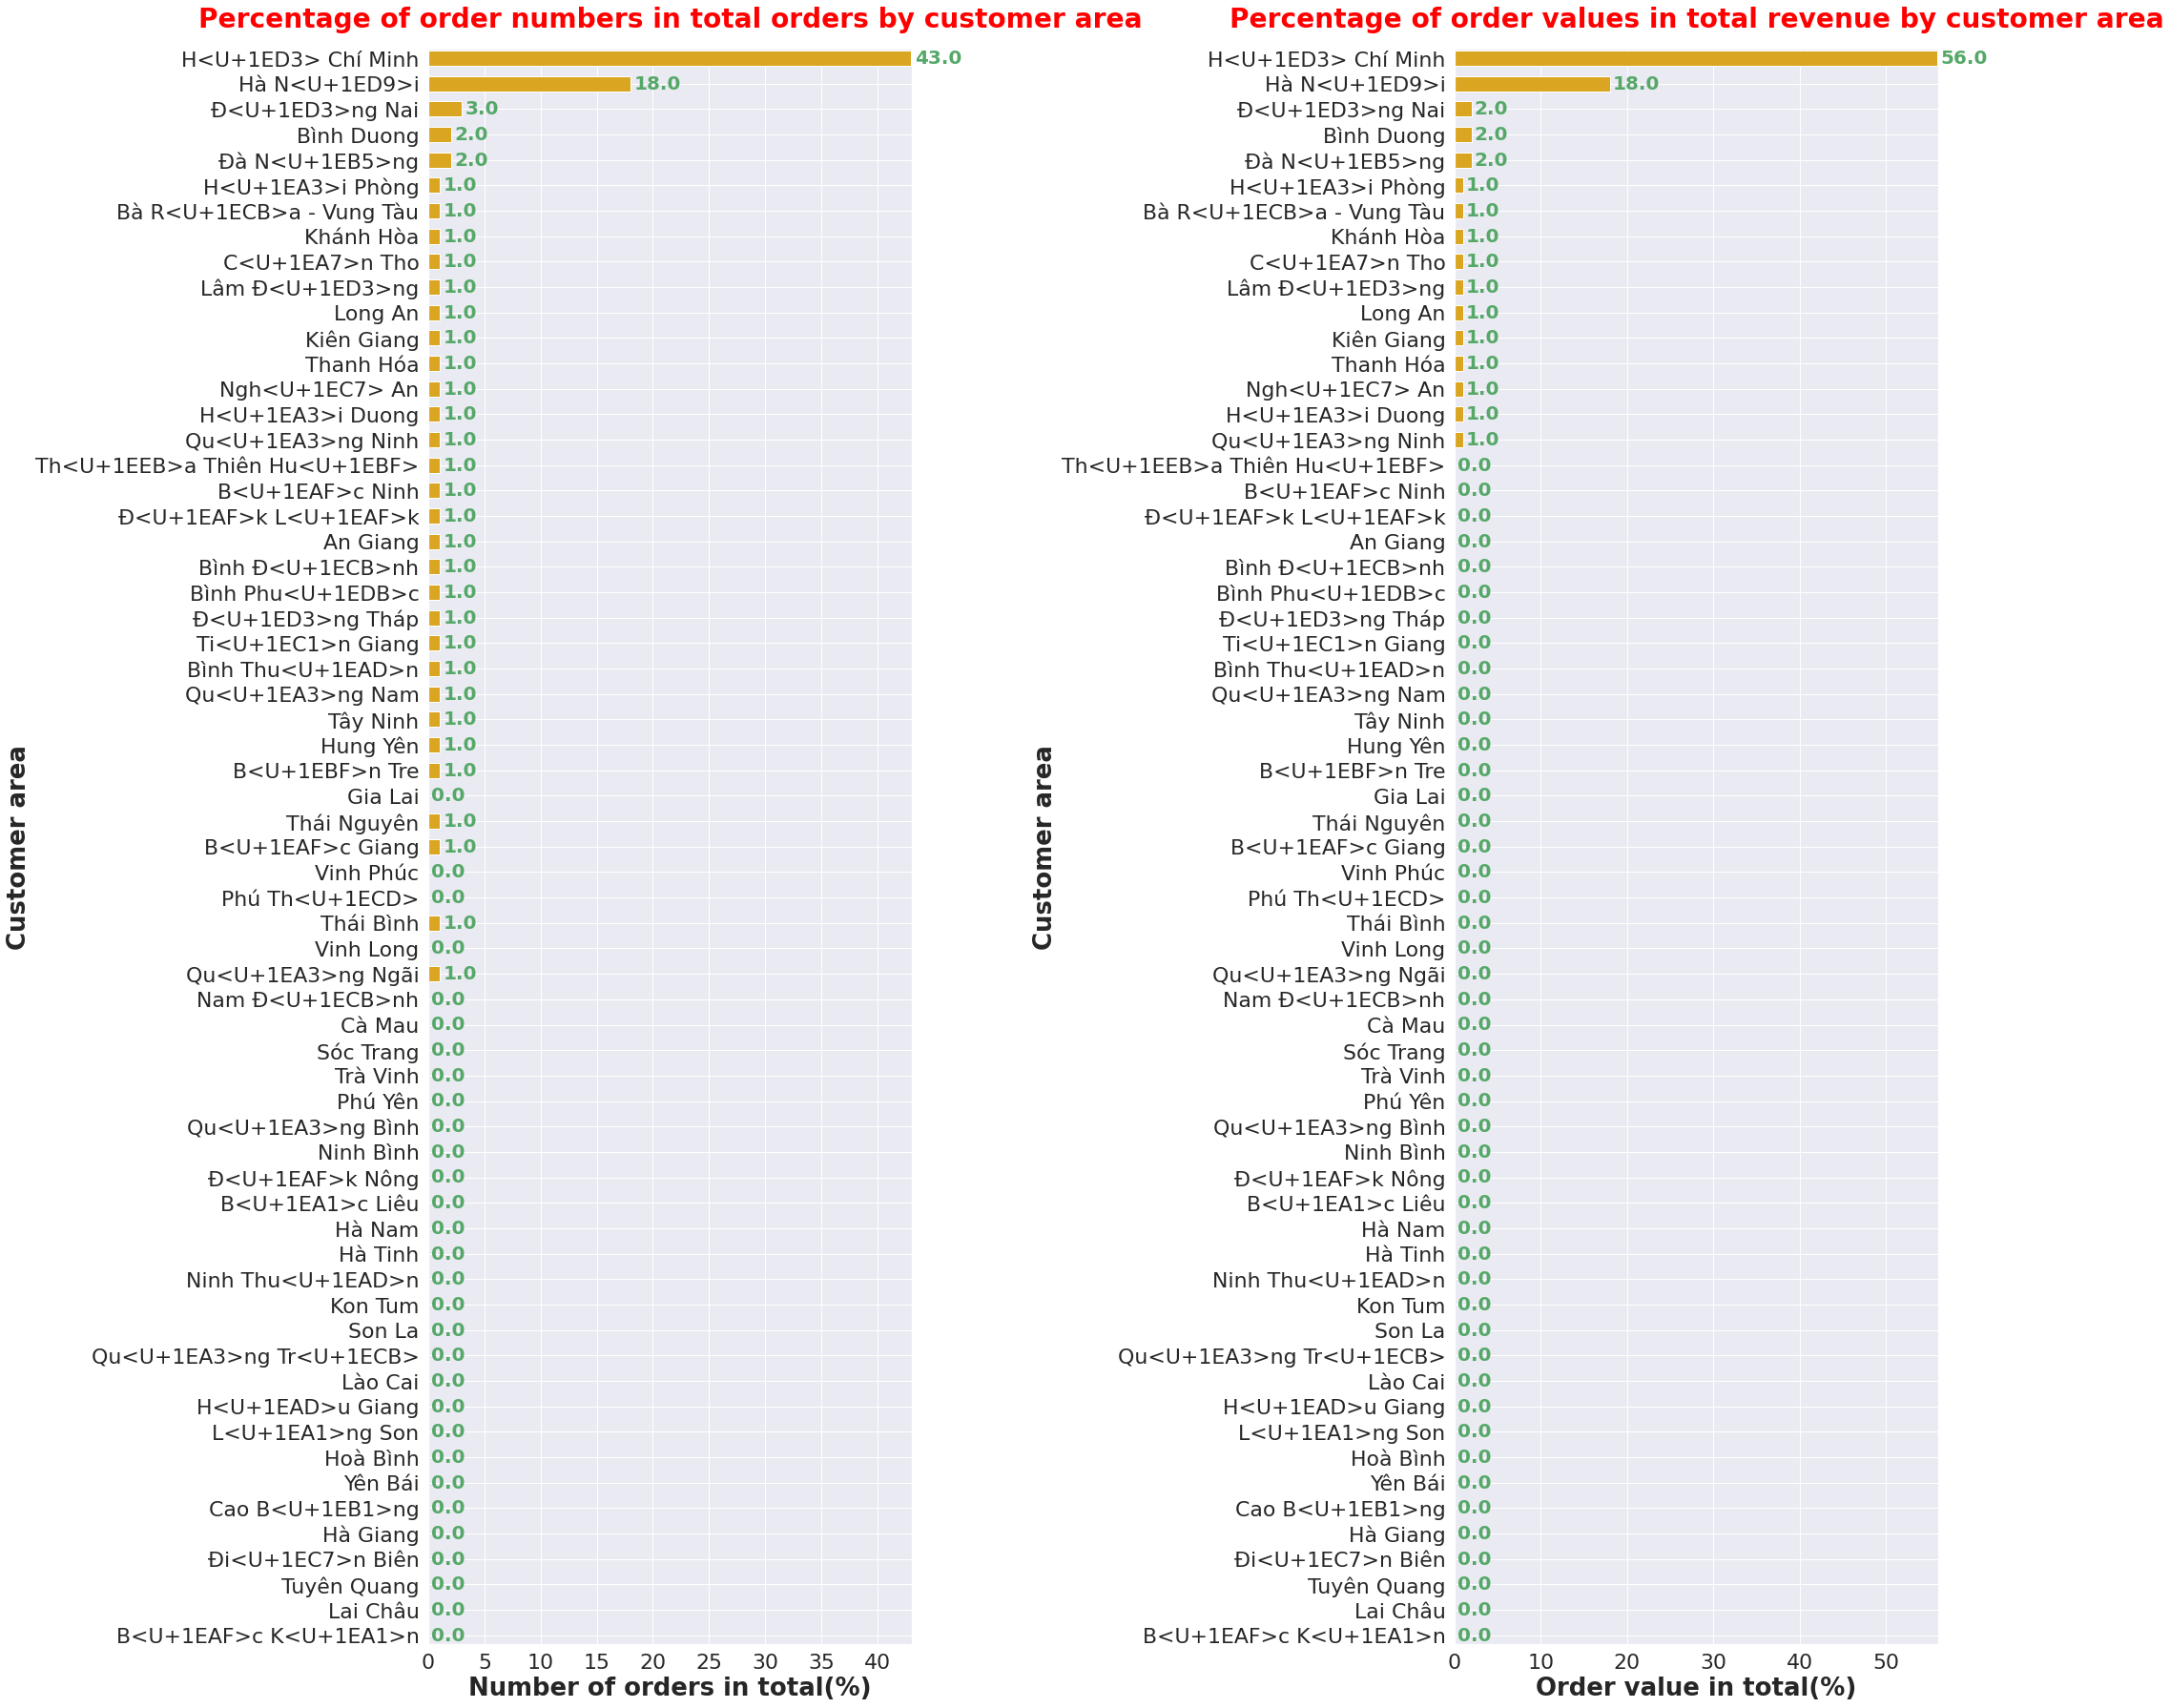

In [307]:
# Plot number of orders and order value by customer_area
x=Order_by_area['customer_area']
y=Order_by_area['% No orders in total']
y1=Order_by_area['% Order value in total']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,25))

## Graph % Number of orders in total by customer area
plt.subplot(1,2,1)
plt.barh(x, y, color='goldenrod', height=0.6)
plt.title('Percentage of order numbers in total orders by customer area',color='red',fontsize=28,fontweight='bold',y=1.01)
plt.xlabel('Number of orders in total(%)',fontsize=26, fontweight='bold')
plt.ylabel('Customer area',fontsize=26,fontweight='bold')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
for i, v in enumerate(y):
    plt.text(v+0.3, i-.20 , str(v),fontsize = 20, fontweight ='bold', color ='g')
plt.margins(0.001)

## Graph % Order value in total by customer area
plt.subplot(1,2,2)
plt.barh(x, y1, color='goldenrod', height=0.6)
plt.title('Percentage of order values in total revenue by customer area',color='red',fontsize=28,fontweight='bold',y=1.01)
plt.xlabel('Order value in total(%)',fontsize=26, fontweight='bold')
plt.ylabel('Customer area',fontsize=26,fontweight='bold')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
for i, v in enumerate(y1):
    plt.text(v+0.3, i-.20 , str(v),fontsize = 20, fontweight ='bold', color ='g')
plt.margins(0.001)
plt.tight_layout()

# Display top 10 customer area by Order value and Number of orders
Top10_customer_area=Order_by_area.loc[53:62,['customer_area','% No orders in total','% Order value in total']].\
sort_values('% Order value in total',ascending=False).reset_index()
Top10_customer_area.drop(columns={'index'},inplace=True)
Top10_customer_area.loc['Grand_Total']= Top10_customer_area.sum(numeric_only=True, axis=0)
print('Top 10 customer area by Order value and Number of orders')
display(Top10_customer_area)

Based on the data from the table & graph, it is easy to see that the top 10 potential customer cities in order are: Ho Chi Minh, Ha Noi, Da Nang, Binh Duong, Dong Nai, Lam Dong, Can Tho, Khanh Hoa, Ba Ria-Vung Tau,  Hai Phong.

They contribute for **73%** number of orders and **85%** order value in total at Tiki => should take care them more

>>>*2.4.2  How is the performance of delivery lead-time? 2 hours, 1 days, 2 days and so on?*

In [308]:
# Set "giao_hang_thanh_cong" status of order as "complete" because they have same meaning
df['status']=np.where(df['status']=='giao_hang_thanh_cong','complete',df['status'])

In [309]:
# Get "deliveried_order" table from df
deliveried_order=df[df['status']=='complete']
deliveried_order=deliveried_order.fillna(0)
deliveried_order=deliveried_order[deliveried_order['actual_delivery']!=0]
deliveried_order=deliveried_order[deliveried_order['actual_fulfilled']!=0]
deliveried_order['delivery_time(days)']=(deliveried_order['actual_delivery']-deliveried_order['actual_fulfilled']).dt.days
deliveried_order=deliveried_order[deliveried_order['delivery_time(days)']>0]
deliveried_order['delivery_leadtime']=(pd.to_datetime(deliveried_order['delivery_deadline'])-\
                                       pd.to_datetime(deliveried_order['actual_fulfilled'])).dt.days
deliveried_order['delivery_performance']=(pd.to_datetime(deliveried_order['actual_delivery'])-\
                                          pd.to_datetime(deliveried_order['delivery_deadline'])).dt.days  
deliveried_order['on-time_delivery']=np.where(deliveried_order['delivery_performance']>0,0,1)                                                                              

In [310]:
# Determine On-time delivery performance for different lead-time: 2 hours, 1 days, 2 days and so on
## Create a function that operates on the row like so:
def f(row):
  if   row['is_2h'] == 1 :
        val="2 hours"
  elif row['is_2h'] == 0 and row['delivery_leadtime'] ==1 :
        val="1 day"
  elif row['delivery_leadtime'] ==2 :
        val="2 days"     
  elif row['delivery_leadtime'] ==3 :
        val="3 days"   
  elif row['delivery_leadtime'] ==4 :
        val="4 days" 
  elif row['delivery_leadtime'] ==5 :
        val="5 days"      
  elif row['delivery_leadtime'] ==6 :
        val="6 days"
  elif row['delivery_leadtime'] ==7 :
        val="7 days"  
  elif row['delivery_leadtime'] ==8 :
        val="8 days"  
  else:
        val="other"
  return val
## Then apply to "deliver_order" to add new column "delivery_leadtime_category" by passing in the axis=1 option:
deliveried_order['delivery_leadtime_category']=deliveried_order.apply(f,axis=1)
## Get "delivery_performance" table from "deliveried_order"
delivery_performance=deliveried_order.groupby('delivery_leadtime_category').\
agg({'order_id':'count', 'on-time_delivery':'sum'}).reset_index()
delivery_performance['% performance']=round(delivery_performance['on-time_delivery']/delivery_performance['order_id']*100,0)
delivery_performance=delivery_performance[:9].sort_values('% performance', ascending=False)
delivery_performance=delivery_performance.rename(columns={'order_id':'Number of deliveried order_id',\
                                                          'on-time_delivery':'Number on-time_delivery orders'})

On-time delivery performance of shipped orders is: 83.0 %
--------------------------------------------------------------------------------------------------------------------------------------------


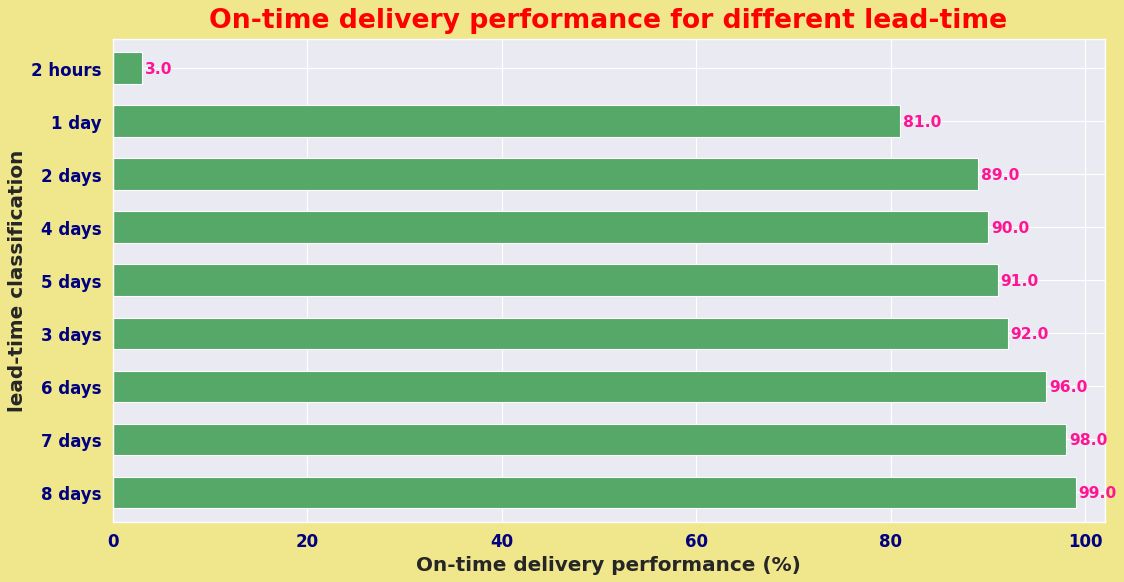

In [311]:
# Print on-time performance of deliveried order
a=round(deliveried_order['on-time_delivery'].sum()/deliveried_order['order_id'].count()*100,1)
print('On-time delivery performance of shipped orders is:',a,'%')
print('-'*140)
# Graph of On-time delivery performance for different lead time
x=delivery_performance['delivery_leadtime_category']
y=delivery_performance['% performance']
plt.figure(num=None, figsize=(16,8),dpi=80, facecolor='khaki',edgecolor='k')
plt.barh(x, y, color='g', height=0.6)
plt.title('On-time delivery performance for different lead-time',color='red',fontsize=24,fontweight='bold',y=1.01)
plt.xlabel('On-time delivery performance (%)',fontsize=18, fontweight='bold')
plt.ylabel('lead-time classification',fontsize=18,fontweight='bold')
plt.xticks(fontsize=15,color='navy',fontweight='bold')
plt.yticks(fontsize=15,color='navy',fontweight='bold')
for i, v in enumerate(y):
    plt.text(v+0.3, i-.10 , str(v),fontsize = 14, fontweight ='bold', color ='deeppink')
plt.margins(0.03)

On-time delivery performance of shipped orders is: **83%** . In which, performance of  "2hours" lead-time is very low, achieving **3%** only, for  "1day"  lead-time is **81%**, the rest of lead-times  are much higher (**>=89%**). It seems that, the longer lead-time, the better on-time delivery performance.

=> should to improve delivery performance for **"2hours" lead-time**

>>>*2.4.3  Evaluate the failed delivery rate and the reason behind it*

In [312]:
# Get "dispatched order" table from df
dispatched_order=df[(df['status']=='canceled')|(df['status']=='ban_giao_doi_tac')|\
                    (df['status']=='len_ke')|(df['status']=='dang_van_chuyen')|(df['status']=='complete')]
dispatched_order = dispatched_order[dispatched_order['actual_outstock'].notna()]  
dispatched_order = dispatched_order[dispatched_order['actual_fulfilled'].notna()] 

Failed delivery rate is: 4.0 %
--------------------------------------------------------------------------------------------------------------------------------------------


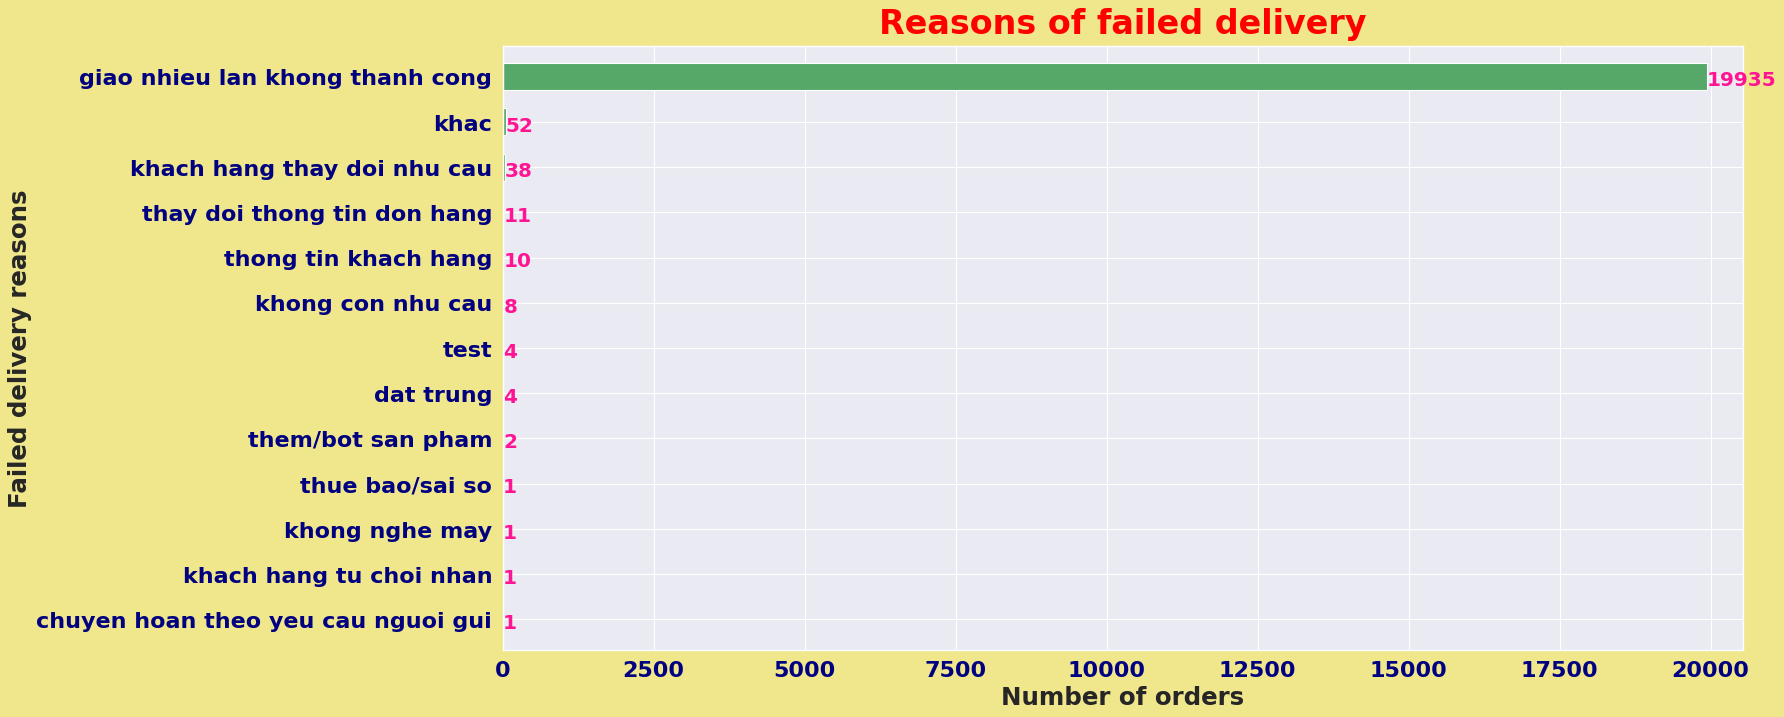

In [313]:
# Print failed delivery rate
failed_delivery_rate=round(dispatched_order['fail_delivery'].sum()/dispatched_order['order_id'].count()*100,0)
print('Failed delivery rate is:',failed_delivery_rate,'%')
print('-'*140)
# Reasons for failed delivery
failed_delivery=dispatched_order[dispatched_order['fail_delivery']==1]
b=failed_delivery.groupby('reason_cancel/fail_delivery')['order_id'].count().reset_index().sort_values('order_id') 
# Graph of failed delivery for different reasons
x=b['reason_cancel/fail_delivery']
y=b['order_id']
plt.figure(num=None, figsize=(20,10),dpi=80, facecolor='khaki',edgecolor='k')
plt.barh(x, y, color='g', height=0.6)
plt.title('Reasons of failed delivery',color='red',fontsize=30,fontweight='bold',y=1.01)
plt.xlabel('Number of orders',fontsize=22, fontweight='bold')
plt.ylabel('Failed delivery reasons',fontsize=22,fontweight='bold')
plt.xticks(fontsize=20,color='navy',fontweight='bold')
plt.yticks(fontsize=20,color='navy',fontweight='bold')
for i, v in enumerate(y):
    plt.text(v+0.3, i-.20 , str(v),fontsize = 18, fontweight ='bold', color ='deeppink')
plt.margins(0.03)

As calculated, the failure rate of delivered orders is **4%** because the majority due to unsuccessful repeated delivery. This can come from some reasons: wrong address, customer is stucking in some thing, etc => should investigate more to improve it

>>>*2.4.4  Evaluate the cancellation rate*

In [314]:
# Add "cancellation" column into df
## Create a function that operates on the row like so:
def f1(row):
  if   row['status'] == 'canceled' :
        val=1
  else:
        val=0
  return val
## Then apply to df by passing in the axis=1 option:
df['cancellation']=df.apply(f1,axis=1)

Cancellation rate of purchased order is: 20.0 %
--------------------------------------------------------------------------------------------------------------------------------------------


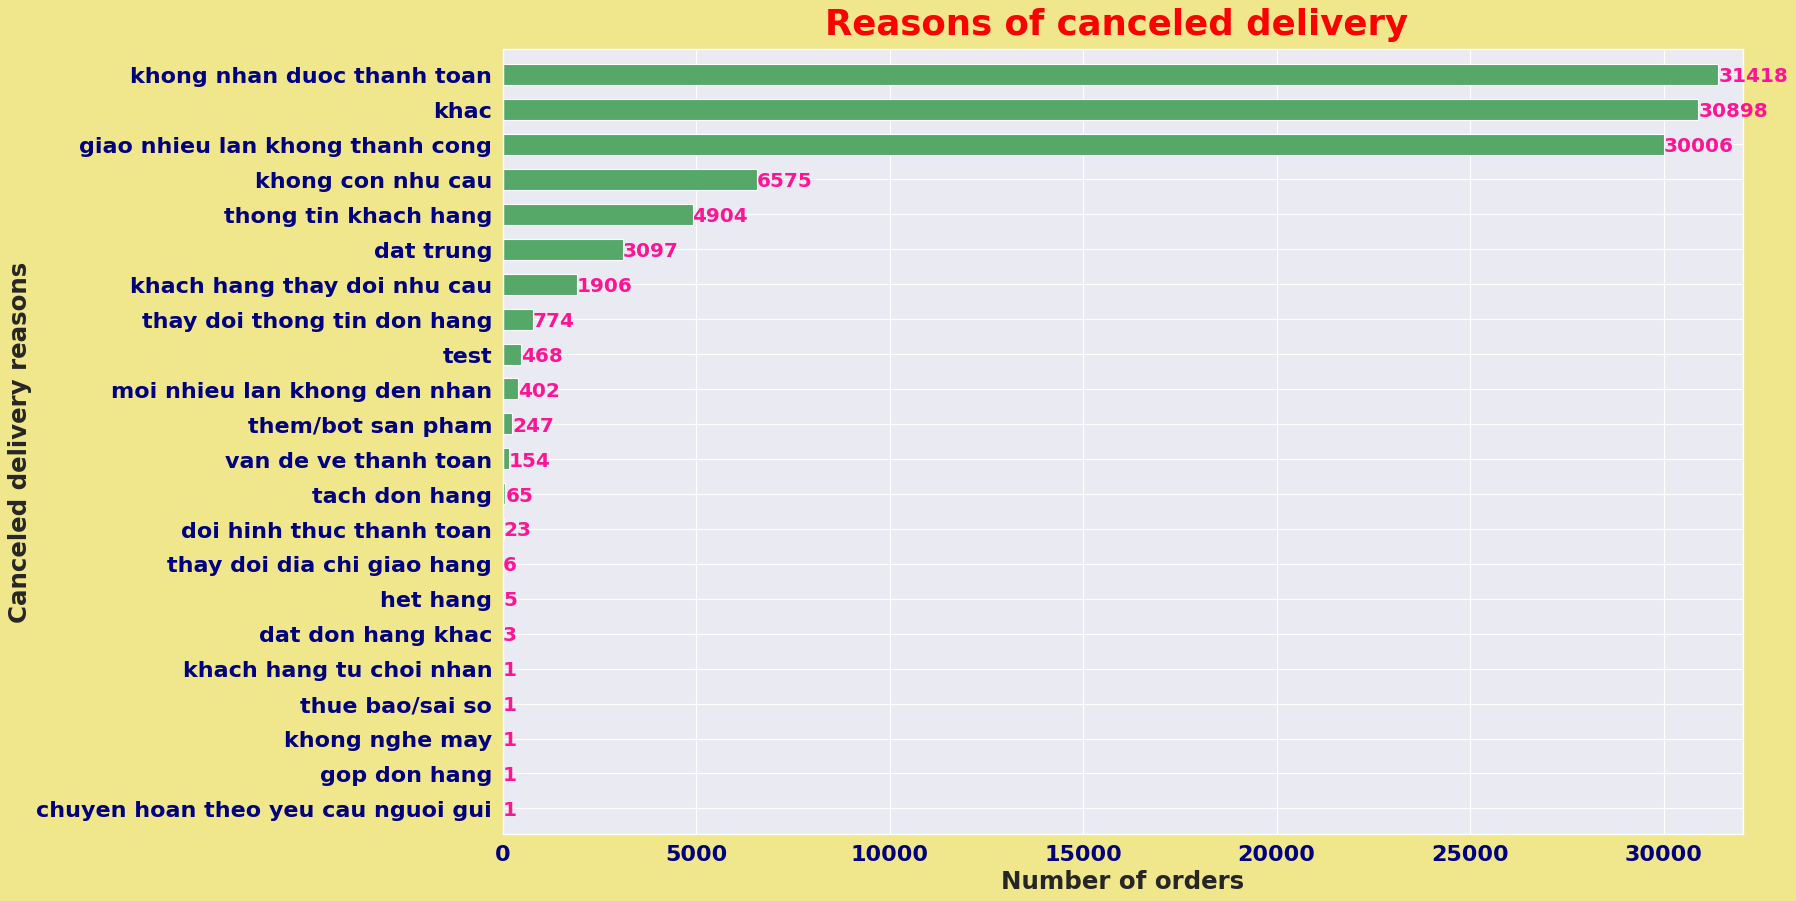

In [315]:
# Print the cancellation rate
cancellation_rate=round(df['cancellation'].sum()/df['order_id'].count()*100,0)
print('Cancellation rate of purchased order is:',cancellation_rate,'%')
print('-'*140)
# Reasons for failed delivery
cancellation=df[df['cancellation']==1]
c=cancellation.groupby('reason_cancel/fail_delivery')['order_id'].count().reset_index().sort_values('order_id') 
# Graph of canceled delivery for different reasons
x=c['reason_cancel/fail_delivery']
y=c['order_id']
plt.figure(num=None, figsize=(20,13),dpi=80, facecolor='khaki',edgecolor='k')
plt.barh(x, y, color='g', height=0.6)
plt.title('Reasons of canceled delivery ',color='red',fontsize=32,fontweight='bold',y=1.01)
plt.xlabel('Number of orders',fontsize=22, fontweight='bold')
plt.ylabel('Canceled delivery reasons',fontsize=22,fontweight='bold')
plt.xticks(fontsize=20,color='navy',fontweight='bold')
plt.yticks(fontsize=20,color='navy',fontweight='bold')
for i, v in enumerate(y):
    plt.text(v+0.3, i-.20 , str(v),fontsize = 18, fontweight ='bold', color ='deeppink')
plt.margins(0.02)

Based on data provided, the cancellation rate of purchased orders is **20%**. Top 3 reasons are: payment has not been received, unsuccessful repeated delivery and others. In addition to, the next one is customer no longer need to buy goods

>**3. CONCLUSION**

Based on data analytics above, getting some insights and offer recommend as below

1. Strengthen marketing campaigns in the morning and afternoon hours, especially on the first days of the week when customers have high buying demand to increase orders and sales

2.  Prioritize allocating resources and promoting customer care services to key areas such as: Ho Chi Minh, Ha Noi, Binh Duong, Dong Nai, Da Nang, etc

3. Figure out  root cause and improve  on-time delivery performance for orders with lead-time is 2 hours, next is "1day" lead-time

4. Find out the reasons behind failure delivery and cancellation then develop strategy to reduce them such as
* It’s very often down to addresses being incorrectly entered by users during the checkout process -> highlighting the delivery address of orders, as well estimated arrival dates (and times, wherever possible) in every notification you send – including order confirmation emails, dispatch emails, as well as delivery notification text messages

* Automated Notifications on Delivery Day: For example, self-service text capability means customers can receive an update saying, “We’re 30 minutes away – are we still okay with this delivery time?” If the customer is stuck in traffic, they can choose a later time slot.

* Validate the address and phone number before shipping any order, check if the phone number provided by the customer is correct